### Notebook to prototype REDCap API calls

In [1]:
import pandas as pd
import numpy as np
import requests
import json
import nipoppy.workflow.logger as my_logger
import seaborn as sns
import nipoppy.workflow.utils as utils
from itertools import product

In [2]:
def api_call(url, query, logger):
    r = requests.post(url, data=query, verify=False)
    http_status = str(r.status_code)
    logger.info(f'HTTP Status: {http_status}')

    if http_status == "200":
        query_results = r.json()
        query_df = pd.DataFrame(query_results)

    else:
        logger.error(f"RedCap API request Failed with HTTP Status: {http_status}")

    return query_df

In [3]:
DATASET_ROOT = "/home/nikhil/projects/Parkinsons/qpn/"

# Current nipoppy manifest
release_dir = f"{DATASET_ROOT}/releases/"
current_release = "Sept_2023"
current_nipoppy_manifest_csv = f"{release_dir}{current_release}/tabular/manifest.csv"
legacy_qpn_imaging_codes_xlsx = f"{release_dir}{current_release}/tabular/QPN_Imaging_Codes.xlsx"

# log
log_dir = f"{DATASET_ROOT}/scratch/logs/"
log_file = f"{log_dir}/bids_conv.log"
logger = my_logger.get_logger(log_file)

# Available queires (i.e. redcap reports)
# redcap_reports = ["QPN participants", "External QPN (June 2021)", "MoCA-MDS-UPDRS part 3", "Victoria - Weston Project",
#                   "MotorAndNon-Motor"]

### Manifest

In [4]:
visit_list = ["MRI_v1"] 
session_id_list = ["01"]
session_list = [f"ses-{idx}" for idx in session_id_list]

manifest_cols = ["participant_id", "visit", "session"]

current_nipoppy_manifest_df = pd.read_csv(current_nipoppy_manifest_csv)
current_nipoppy_manifest_df = current_nipoppy_manifest_df[current_nipoppy_manifest_df["visit"].isin(visit_list)]
current_nipoppy_manifest_df = current_nipoppy_manifest_df[current_nipoppy_manifest_df["session"].isin(session_list)]
current_nipoppy_manifest_df = current_nipoppy_manifest_df[manifest_cols]
nipoppy_participants = current_nipoppy_manifest_df["participant_id"].unique()
nipoppy_participants = [p.upper() for p in nipoppy_participants]
n_participants = len(nipoppy_participants)
logger.info(f"n_participants: {n_participants}")
current_nipoppy_manifest_df.head()

n_participants: 265


,participant_id,visit,session
0,PD00016,MRI_v1,ses-01
1,PD00020,MRI_v1,ses-01
2,PD00032,MRI_v1,ses-01
3,PD00048,MRI_v1,ses-01
4,PD00119,MRI_v1,ses-01


### Legacy demographics and visit dates
- Using this while REDCap is getting updated

In [5]:
sheet_name = "recruit_manifest"
usecols = ["participant_id", "group", "sex", "dob", "visit_01"]
legacy_recruit_manifest = pd.read_excel(legacy_qpn_imaging_codes_xlsx, sheet_name=sheet_name, engine='openpyxl', usecols=usecols)
legacy_recruit_manifest = legacy_recruit_manifest.rename(columns={"visit_01": "date_MRI_V01"})

legacy_participants = legacy_recruit_manifest["participant_id"].unique()
legacy_participants = [p.upper() for p in legacy_participants]
n_legacy_participants = len(legacy_participants)
logger.info(f"n_legacy_participants: {n_legacy_participants}")

legacy_recruit_manifest["dob"] = pd.to_datetime(legacy_recruit_manifest["dob"], errors="coerce", dayfirst=True)
legacy_recruit_manifest["date_MRI_V01"] = pd.to_datetime(legacy_recruit_manifest["date_MRI_V01"], errors="coerce", dayfirst=True)

# calculate age at MRI_V01
legacy_recruit_manifest["age_MRI_V01"] = legacy_recruit_manifest["date_MRI_V01"] - legacy_recruit_manifest["dob"]
legacy_recruit_manifest["age_MRI_V01"] = np.round(legacy_recruit_manifest["age_MRI_V01"].dt.days / 365.25, 1)
legacy_recruit_manifest.head()


n_legacy_participants: 208


,participant_id,sex,dob,group,date_MRI_V01,age_MRI_V01
0,MNI0056,M,1942-05-21,PD,2021-08-18,79.2
1,MNI0058,M,1964-03-14,PD,2021-08-18,57.4
2,MNI0068,M,1952-08-05,PD,2021-08-27,69.1
3,MNI0079,F,1971-11-25,PD,2021-12-22,50.1
4,MNI0103,M,1939-08-17,PD,2021-08-11,82.0


In [6]:
legacy_recruit_manifest.groupby("group").count()

,participant_id,sex,dob,date_MRI_V01,age_MRI_V01
group,,,,,
CTRL,41,41,40,41,40
PD,166,166,166,166,166


### Redcap config

In [7]:
redcap_config_json = f"{DATASET_ROOT}/proc/.redcap.json"
redcap_config = json.load(open(redcap_config_json))
url = redcap_config["url"]
redcap_reports = list(redcap_config["queries"].keys())
n_redcap_reports = len(redcap_reports)
logger.info(f"redcap_reports ({n_redcap_reports}): {redcap_reports}")

2023-10-31 19:57:47,769 - nipoppy.workflow.logger - INFO - redcap_reports (10): ['QPN participants', 'External QPN (June 2021)', 'Demographic QPN', 'QPN-Clinical questionnaire', 'QPN sex', 'Diagnosis QPN', 'MoCA-MDS-UPDRS part 3', 'Victoria - Weston Project', 'MotorAndNon-Motor', 'MoCA']


In [8]:
query_dict = {}
redcap_participants = []
for query_label in redcap_reports:
    query = redcap_config["queries"][query_label]

    # run query
    logger.info(f"Running query {query_label}...")
    query_df = api_call(url, query, logger=logger)

    # get the list of participants
    _participants = query_df["record_id"].unique()
    redcap_participants.extend(_participants)
    n_participants = len(redcap_participants)

    # get the list of redcap events
    redcap_events = query_df["redcap_event_name"].unique()
    n_events = len(redcap_events)

    logger.info(f"Fetched {n_participants} participants and {n_events} event_ids: {redcap_events}")

    query_dict[query_label] = query_df.copy()

2023-10-31 19:57:49,154 - nipoppy.workflow.logger - INFO - Running query QPN participants...
/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host 'redcap.cru.ucalgary.ca'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
2023-10-31 19:57:50,247 - nipoppy.workflow.logger - INFO - HTTP Status: 200
2023-10-31 19:57:50,250 - nipoppy.workflow.logger - INFO - Fetched 264 participants and 7 event_ids: ['Baseline (Arm 1: C-OPN)' '12 Months Follow-Up/Suivi (Arm 1: C-OPN)'
 '18 Months Follow-Up/Suivi (Arm 1: C-OPN)'
 '72 Months Follow-Up/Suivi (Arm 1: C-OPN)'
 '60 Months Follow-Up/Suivi (Arm 1: C-OPN)'
 '36 Months Follow-Up/Suivi (Arm 1: C-OPN)'
 '24 Months Follow-Up/Suivi (Arm 1: C-OPN)']
2023-10-31 19:57:50,250 - nipoppy.workflow.logger - INFO - Running query External QPN (June 2

In [10]:
redcap_participants = [p.upper() for p in redcap_participants]

a = set(redcap_participants)
b = set(nipoppy_participants)
c = set(legacy_participants)

nipoppy_redcap_common_participants = a.intersection(b)
n_redcap_common_participants = len(nipoppy_redcap_common_participants)
nipoppy_legacy_common_participants = b.intersection(c)
n_legacy_common_participants = len(nipoppy_legacy_common_participants)

new_redcap_participants  = a.difference(b)
n_new_redcap_participants = len(new_redcap_participants)
new_nipoppy_participants  = b.difference(a)
n_new_nipoppy_participants = len(new_nipoppy_participants)

logger.info(f"Found {n_redcap_common_participants} recdap-nipoppy common participants")
logger.info(f"Found {n_legacy_common_participants} legacy-nipoppy common participants")
logger.info(f"Found {n_new_redcap_participants} new redcap participants")
logger.info(f"Found {n_new_nipoppy_participants} new nipoppy participants")

2023-10-31 19:58:29,279 - nipoppy.workflow.logger - INFO - Found 256 recdap-nipoppy common participants
2023-10-31 19:58:29,280 - nipoppy.workflow.logger - INFO - Found 206 legacy-nipoppy common participants
2023-10-31 19:58:29,282 - nipoppy.workflow.logger - INFO - Found 1068 new redcap participants
2023-10-31 19:58:29,282 - nipoppy.workflow.logger - INFO - Found 9 new nipoppy participants


### Demographics, Dx, and summary clinical scores
- `Demographic QPN`
    - "study_visit_age", "gender", "yrs_education"
        - Note: study visit age will be different for different assessments
- `Diagnosis QPN` does not have Dx for all participants
- `Victoria - Weston Project` (Legend for Determined diagnosis)
    - If score = 0, Parkinson's Disease (PD)  
    - If score = 1, Progressive Supranuclear Palsy (PSP)  
    - If score = 2, Multiple System Atrophy (MSA) 
    - If score = 3, Corticobasal Syndrome (CBS)  
    - If score = 4, Dementia wi1th Lewy Bodies (DLB)  
    - If score = 5, Frontotemporal Dementia (FTD)  
    - If score = 6, Essential Tremor (ET)  
    - If score = 7, REM Sleep Behaviour Disorder (RBD)
- `MotorAndNon-Motor` 
    - summary clinical scores (updrs, moca)
    - verify moca column with extra point i.e. `moca_extra_point`


### Aggregate useful redcap data

In [11]:
index_columns = ["record_id", "redcap_event_name"]

demo_cols = ["study_visit_age", "gender", "yrs_education"]
demo_df = query_dict['Demographic QPN'][index_columns + demo_cols].copy()

dx_cols = ["diagnosis_determined", "duration_disease"]
dx_df = query_dict['Victoria - Weston Project'][index_columns + dx_cols]

diagnosis_determined_label_map = {
    "0" : "PD",
    "1" : "PSP",
    "2" : "MSA",
    "3" : "CBS", 
    "4" : "DLB",
    "5" : "FTD", 
    "6" : "ET",
    "7" : "RBD"
}
dx_df.loc[:,"diagnosis_determined"] = dx_df["diagnosis_determined"].astype(str).replace(diagnosis_determined_label_map).copy()

updrs_cols = ["mds_updrs_h_y", "updrs_score_part_1", "updrs_score_part_2", "updrs_score_part_3", "updrs_score_part_4"]
moca_cols = ['moca_result'] 
moca_subscore_cols = ['moca_result_2', 'moca_result_3', 'moca_result_4','moca_result_5', 'moca_result_6', 
                      'moca_result_7', 'moca_result_8','moca_result_9']

score_cols = updrs_cols + moca_cols
score_df = query_dict["Victoria - Weston Project"][index_columns + score_cols].copy()

redcap_df = pd.merge(demo_df, dx_df, on=index_columns)
redcap_df = pd.merge(redcap_df, score_df, on=index_columns)

n_redcap_common_participants = len(redcap_df["record_id"].unique())
logger.info(f"Found {n_redcap_common_participants} recdap-nipoppy common participants")

logger.info(f"redcap events: {redcap_df['redcap_event_name'].unique()}")

redcap_df.head()

2023-10-31 19:58:32,650 - nipoppy.workflow.logger - INFO - Found 1324 recdap-nipoppy common participants
2023-10-31 19:58:32,652 - nipoppy.workflow.logger - INFO - redcap events: ['Baseline (Arm 1: C-OPN)']


,record_id,redcap_event_name,study_visit_age,gender,yrs_education,diagnosis_determined,duration_disease,mds_updrs_h_y,updrs_score_part_1,updrs_score_part_2,updrs_score_part_3,updrs_score_part_4,moca_result
0,CHQ0000,Baseline (Arm 1: C-OPN),,Female/Féminin,9,,,,,,,,
1,chq0009,Baseline (Arm 1: C-OPN),,,,,,,,,,,
2,CHQ0011,Baseline (Arm 1: C-OPN),70,Male/Masculin,16,PD,5.8,(2) Bilateral involvement without impairment o...,11,8,36,0,24
3,CHQ0012,Baseline (Arm 1: C-OPN),,,,,,,,,,,
4,CHQ0035,Baseline (Arm 1: C-OPN),71,Female/Féminin,14,PD,11.8,(2) Bilateral involvement without impairment o...,6,11,46,7,22


### Merge MRI, legacy and redcap tabular data

In [72]:
nipoppy_redcap_df = redcap_df[(redcap_df["record_id"].str.upper().isin(nipoppy_participants)) & 
                              (redcap_df["redcap_event_name"].isin(["Baseline (Arm 1: C-OPN)"]))].copy()

n_nipoppy_redcap_participants = len(nipoppy_redcap_df["record_id"].unique())
logger.info(f"n_nipoppy_redcap_participants: {n_nipoppy_redcap_participants}")

               
nipoppy_redcap_df = nipoppy_redcap_df.replace("", np.nan)
nipoppy_redcap_df = nipoppy_redcap_df.rename(columns={"record_id": "participant_id"})

nipoppy_redcap_df = pd.merge(nipoppy_redcap_df, legacy_recruit_manifest, on="participant_id", how="left")
nipoppy_redcap_df["gender"] = nipoppy_redcap_df["gender"].replace({"Male/Masculin":"M", "Female/Féminin":"F"})

n_nipoppy_redcap_participants = len(nipoppy_redcap_df["participant_id"].unique())
logger.info(f"n_nipoppy_redcap_participants: {n_nipoppy_redcap_participants}")

redcap_events = nipoppy_redcap_df["redcap_event_name"].unique()
logger.info(f"redcap_events: {redcap_events}")

nipoppy_redcap_df.head()

2023-10-31 20:34:58,085 - nipoppy.workflow.logger - INFO - n_nipoppy_redcap_participants: 256
2023-10-31 20:34:58,091 - nipoppy.workflow.logger - INFO - n_nipoppy_redcap_participants: 256
2023-10-31 20:34:58,092 - nipoppy.workflow.logger - INFO - redcap_events: ['Baseline (Arm 1: C-OPN)']


,participant_id,redcap_event_name,study_visit_age,gender,yrs_education,diagnosis_determined,duration_disease,mds_updrs_h_y,updrs_score_part_1,updrs_score_part_2,updrs_score_part_3,updrs_score_part_4,moca_result,sex,dob,group,date_MRI_V01,age_MRI_V01
0,MNI0056,Baseline (Arm 1: C-OPN),79,M,6,NaN,6.1,(3) Bilateral disease: mild to moderate disabi...,12,22,58,0,22,M,1942-05-21,PD,2021-08-18,79.2
1,MNI0058,Baseline (Arm 1: C-OPN),57,M,11,PD,3.4,"(1) Unilateral involvement only, usually with ...",0,6,26,0,25,M,1964-03-14,PD,2021-08-18,57.4
2,MNI0068,Baseline (Arm 1: C-OPN),69,M,12,PD,9.8,(2) Bilateral involvement without impairment o...,11,8,28,0,NaN,M,1952-08-05,PD,2021-08-27,69.1
3,MNI0079,Baseline (Arm 1: C-OPN),49,F,20+,PD,6.5,(2) Bilateral involvement without impairment o...,13,10,22,8,26,F,1971-11-25,PD,2021-12-22,50.1
4,MNI0103,Baseline (Arm 1: C-OPN),81,M,18,PD,4.3,(2) Bilateral involvement without impairment o...,28,25,43,NaN,20,M,1939-08-17,PD,2021-08-11,82.0


### Generate bagel(s)
- neuro-bagel
- dash-bagel (currenly this is a melted version of neuro-bagel)

**Note**: QPN has different `visit` names for MRI, UPDRS, MoCA, Neuropsy etc.

Using redcap events as evidence of multiple visits. However we are NOT assuming that two assessments (e.g. UPDRS and MoCA) are co-acquired in the same redcap event. This will be inferred using dates once available. 

In [73]:
legacy_demo_cols = ["sex","group"]
redcap_index_cols = ["participant_id", "redcap_event_name"]
redcap_event_visit_id_dict = {"Baseline (Arm 1: C-OPN)": "v1"}

# These will be appended to all phenotypic visits
time_agnostic_cols = ["gender", "diagnosis_determined"]
time_agnostic_cols_legacy = legacy_demo_cols 
time_agnostic_df = nipoppy_redcap_df[redcap_index_cols + time_agnostic_cols + time_agnostic_cols_legacy].copy()

screen_cols = demo_cols + dx_cols 
[screen_cols.remove(col) for col in time_agnostic_cols]
screen_df = nipoppy_redcap_df[redcap_index_cols + screen_cols].copy()
screen_df["visit"] = "screening"

screen_df.head()

,participant_id,redcap_event_name,study_visit_age,yrs_education,duration_disease,visit
0,MNI0056,Baseline (Arm 1: C-OPN),79,6,6.1,screening
1,MNI0058,Baseline (Arm 1: C-OPN),57,11,3.4,screening
2,MNI0068,Baseline (Arm 1: C-OPN),69,12,9.8,screening
3,MNI0079,Baseline (Arm 1: C-OPN),49,20+,6.5,screening
4,MNI0103,Baseline (Arm 1: C-OPN),81,18,4.3,screening


In [74]:
visit_prefix = "UPDRS_"
updrs_df = nipoppy_redcap_df[redcap_index_cols + updrs_cols].copy()
updrs_df["visit_id"] = updrs_df["redcap_event_name"].map(redcap_event_visit_id_dict)
updrs_df["visit"] = visit_prefix + updrs_df["visit_id"]

updrs_df.head()

,participant_id,redcap_event_name,mds_updrs_h_y,updrs_score_part_1,updrs_score_part_2,updrs_score_part_3,updrs_score_part_4,visit_id,visit
0,MNI0056,Baseline (Arm 1: C-OPN),(3) Bilateral disease: mild to moderate disabi...,12,22,58,0,v1,UPDRS_v1
1,MNI0058,Baseline (Arm 1: C-OPN),"(1) Unilateral involvement only, usually with ...",0,6,26,0,v1,UPDRS_v1
2,MNI0068,Baseline (Arm 1: C-OPN),(2) Bilateral involvement without impairment o...,11,8,28,0,v1,UPDRS_v1
3,MNI0079,Baseline (Arm 1: C-OPN),(2) Bilateral involvement without impairment o...,13,10,22,8,v1,UPDRS_v1
4,MNI0103,Baseline (Arm 1: C-OPN),(2) Bilateral involvement without impairment o...,28,25,43,NaN,v1,UPDRS_v1


In [75]:
visit_prefix = "MoCA_"
moca_df = nipoppy_redcap_df[redcap_index_cols + moca_cols].copy()
moca_df["visit_id"] = moca_df["redcap_event_name"].map(redcap_event_visit_id_dict)
moca_df["visit"] = visit_prefix + moca_df["visit_id"]

moca_df.head()

,participant_id,redcap_event_name,moca_result,visit_id,visit
0,MNI0056,Baseline (Arm 1: C-OPN),22,v1,MoCA_v1
1,MNI0058,Baseline (Arm 1: C-OPN),25,v1,MoCA_v1
2,MNI0068,Baseline (Arm 1: C-OPN),NaN,v1,MoCA_v1
3,MNI0079,Baseline (Arm 1: C-OPN),26,v1,MoCA_v1
4,MNI0103,Baseline (Arm 1: C-OPN),20,v1,MoCA_v1


In [76]:
pheno_df = pd.concat([screen_df, updrs_df, moca_df], axis=0)
pheno_df = pd.merge(pheno_df, time_agnostic_df, on=redcap_index_cols, how="left")

pheno_df.loc[:,"bids_id"] = pheno_df["participant_id"].apply(utils.participant_id_to_bids_id)

reordered_cols = ["participant_id","bids_id","redcap_event_name","visit_id","visit"] + time_agnostic_cols + time_agnostic_cols_legacy + dx_cols + updrs_cols + moca_cols
bagel_df = pheno_df[reordered_cols].copy()
n_participants = len(bagel_df["participant_id"].unique())

logger.info(f"n_nipoppy_participants: {n_participants}")

for col in updrs_cols + moca_cols:
    bagel_df[f"{col}_status"] = ~bagel_df[col].isna()
    n_available_participants = np.sum(bagel_df[f"{col}_status"])
    logger.info(f"{col}, n_available_participants: {n_available_participants}")

logger.info(f"bagel df shape: {bagel_df.shape}")
bagel_df.head()

2023-10-31 20:35:00,788 - nipoppy.workflow.logger - INFO - n_nipoppy_participants: 256
2023-10-31 20:35:00,791 - nipoppy.workflow.logger - INFO - mds_updrs_h_y, n_available_participants: 129
2023-10-31 20:35:00,793 - nipoppy.workflow.logger - INFO - updrs_score_part_1, n_available_participants: 128
2023-10-31 20:35:00,795 - nipoppy.workflow.logger - INFO - updrs_score_part_2, n_available_participants: 127
2023-10-31 20:35:00,798 - nipoppy.workflow.logger - INFO - updrs_score_part_3, n_available_participants: 130
2023-10-31 20:35:00,802 - nipoppy.workflow.logger - INFO - updrs_score_part_4, n_available_participants: 127
2023-10-31 20:35:00,805 - nipoppy.workflow.logger - INFO - moca_result, n_available_participants: 163
2023-10-31 20:35:00,806 - nipoppy.workflow.logger - INFO - bagel df shape: (768, 23)


,participant_id,bids_id,redcap_event_name,visit_id,visit,gender,diagnosis_determined,sex,group,diagnosis_determined,...,updrs_score_part_2,updrs_score_part_3,updrs_score_part_4,moca_result,mds_updrs_h_y_status,updrs_score_part_1_status,updrs_score_part_2_status,updrs_score_part_3_status,updrs_score_part_4_status,moca_result_status
0,MNI0056,sub-MNI0056,Baseline (Arm 1: C-OPN),NaN,screening,M,NaN,M,PD,NaN,...,NaN,NaN,NaN,NaN,False,False,False,False,False,False
1,MNI0058,sub-MNI0058,Baseline (Arm 1: C-OPN),NaN,screening,M,PD,M,PD,PD,...,NaN,NaN,NaN,NaN,False,False,False,False,False,False
2,MNI0068,sub-MNI0068,Baseline (Arm 1: C-OPN),NaN,screening,M,PD,M,PD,PD,...,NaN,NaN,NaN,NaN,False,False,False,False,False,False
3,MNI0079,sub-MNI0079,Baseline (Arm 1: C-OPN),NaN,screening,F,PD,F,PD,PD,...,NaN,NaN,NaN,NaN,False,False,False,False,False,False
4,MNI0103,sub-MNI0103,Baseline (Arm 1: C-OPN),NaN,screening,M,PD,M,PD,PD,...,NaN,NaN,NaN,NaN,False,False,False,False,False,False


### dash bagel (melt)


In [77]:
# Dashboard variables
DASH_INDEX_COLUMNS = ["participant_id", "visit", "bids_id"]
DASH_NAME_COL = "assessment_name"
DASH_VAL_COL = "assessment_score"

dash_df = pheno_df.melt(id_vars=DASH_INDEX_COLUMNS, var_name=DASH_NAME_COL, value_name=DASH_VAL_COL)
dash_df = dash_df.rename(columns={"visit": "session"})


### save bagels

In [78]:
save_bagels = True

bagel_csv_path = f"{DATASET_ROOT}/tabular/bagel.csv"
bagel_tsv_path = f"{DATASET_ROOT}/tabular/bagel.tsv"
dash_csv_path = f"{DATASET_ROOT}/tabular/dash_bagel.csv"

if save_bagels:
    bagel_df.to_csv(bagel_csv_path, index=False)
    bagel_df.to_csv(bagel_tsv_path, index=False, sep="\t")
    dash_df.to_csv(dash_csv_path, index=False)
    logger.info(f"Bagel saved to {dash_csv_path}")

2023-10-31 20:35:05,067 - nipoppy.workflow.logger - INFO - Bagel saved to /home/nikhil/projects/Parkinsons/qpn//tabular/dash_bagel.csv


/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be r

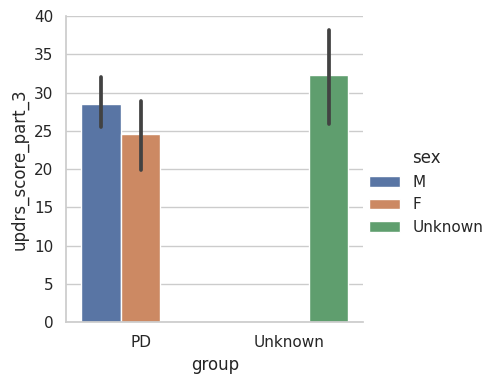

In [81]:
plot_df = pheno_df[pheno_df["redcap_event_name"] == "Baseline (Arm 1: C-OPN)"].copy()

x_col = "group"
hue_col = "sex"
plot_col = "updrs_score_part_3" #"updrs_score_part_3"

plot_df = plot_df[~plot_df[plot_col].isna()]
plot_df[plot_col] = plot_df[plot_col].astype(float)

plot_df[x_col] = plot_df[x_col].fillna("Unknown")
# plot_df[x_col] = plot_df[x_col].astype(str).replace({"":"Unknown"})
plot_df[hue_col] = plot_df[hue_col].fillna("Unknown")
# plot_df[hue_col] = plot_df[hue_col].astype(str).replace({"":"Unknown"})

sns.set(font_scale=1)
with sns.axes_style("whitegrid"):
    # kwargs = {'join':False, "marker":"d", "scale":1, "linewidth":0}
    g = sns.catplot(x=x_col, y=plot_col, hue=hue_col,
                kind="bar", height=4, aspect=1, data=plot_df, 
                # **kwargs
                )

### Detailed clinical scores

In [ ]:
query_df = query_dict["MotorAndNon-Motor"].copy()
query_df = query_df[(query_df["redcap_event_name"] == "Baseline (Arm 1: C-OPN)") & 
                    (query_df["record_id"].isin(nipoppy_participants))]
logger.info(len(query_df))
query_df["updrs_score_part_3"] = query_df["updrs_score_part_3"].replace("", np.nan)
query_df["updrs_score_part_3"] = query_df["updrs_score_part_3"].astype(float)
query_df["updrs_score_part_3"].isna().value_counts()

### CSV Report

In [ ]:
sarah_email_xlsx = "/home/nikhil/Downloads/COPN-VictoriaWestonProjec_DATA_LABELS_2023-10-24_1044.xlsx"
report_df = pd.read_excel(sarah_email_xlsx,sheet_name="COPN-VictoriaWestonProjec_DATA_", engine='openpyxl',header=0)
report_df = report_df.rename(columns={"Record ID:":"record_id"})
report_df.head()

In [ ]:
report_df = report_df[report_df["record_id"].isin(common_participants)]
logger.info(len(report_df))
report_df.head()

In [ ]:
check_col_name = report_df.columns[5]

report_df[check_col_name] = report_df[check_col_name].replace("", np.nan)
logger.info(report_df[check_col_name].notnull().sum())

report_df[check_col_name].value_counts()